In [3]:
%pip install tensorflow tensorflow-gpu matplotlib tensorflow-datasets ipywidgets

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


Requested tensorflow-gpu from https://files.pythonhosted.org/packages/8a/45/fa31ced1db38f9424f262dfbf35747fe5378b5c808cecb373c8cb8e515d3/tensorflow-gpu-2.12.0.tar.gz has invalid metadata: Expected end or semicolon (after name and no valid version specifier)
    python_version>"3.7"
                  ^
Please use pip<24.1 if you need to use this version.
ERROR: Could not find a version that satisfies the requirement tensorflow-gpu (from versions: 2.12.0)
ERROR: No matching distribution found for tensorflow-gpu


In [4]:
%pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [5]:
%pip list

Package                            Version
---------------------------------- --------------
absl-py                            2.1.0
aiohttp                            3.9.5
aiosignal                          1.3.1
alembic                            1.13.1
altair                             4.2.2
aniso8601                          9.0.1
annotated-types                    0.7.0
anyio                              4.4.0
appdirs                            1.4.4
arrow                              1.3.0
astor                              0.8.1
asttokens                          2.4.1
astunparse                         1.6.3
attrs                              23.2.0
backoff                            2.2.1
beautifulsoup4                     4.12.3
blinker                            1.8.2
boto3                              1.34.115
botocore                           1.34.115
cachetools                         5.3.3
certifi                            2023.7.22
chardet                          

In [6]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [7]:
for gpu in gpus:
    print(gpu)

In [8]:
%pip install tensorflow_datasets

Note: you may need to restart the kernel to use updated packages.


In [9]:
#tensorflow datasets import
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

In [10]:
#use tf datasets api to load data
ds = tfds.load('fashion_mnist', split='train')

Viz Data & Build Dataset

In [11]:
#data transformation
import numpy as np

In [12]:
#set up connection (iterator)
dataiterator = ds.as_numpy_iterator()

In [13]:
#getting data out of the pipeline
dataiterator.next()

{'image': array([[[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 18],
         [ 77],
         [227],
         [227],
         [208],
         [210],
         [225],
         [216],
         [ 85],
         [ 32],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 61],
         [100],
         [ 97],
         [ 80],
         [ 57],
         [117],
         [227],
         [238],
         [115],
         [ 49],
         [ 78],
         [106],
         [108],
         [ 71],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         

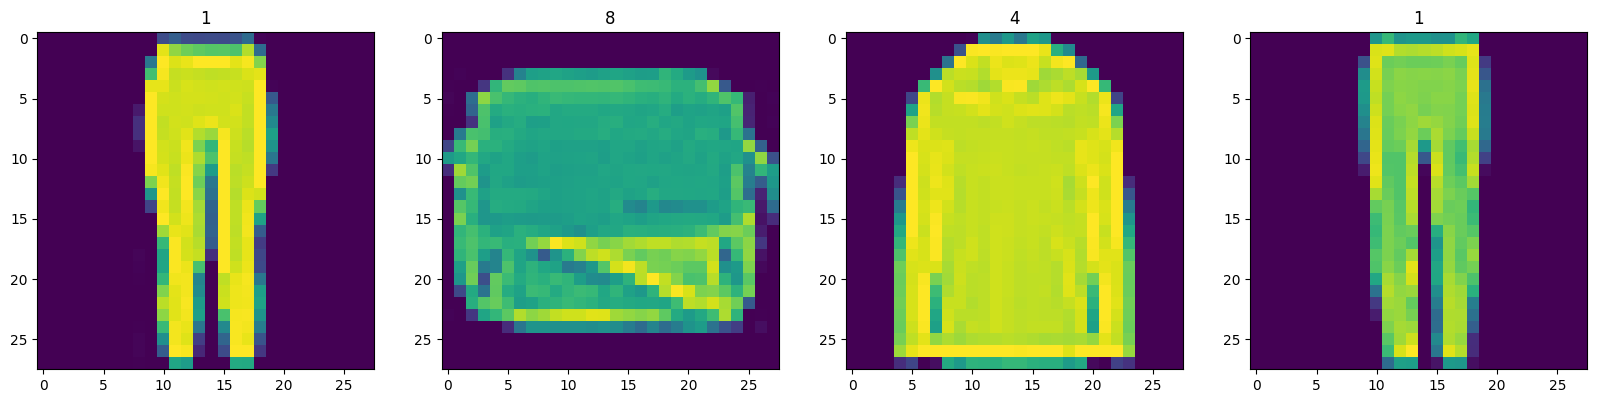

In [14]:
#setup subplot formatting ax- individual subplot
fig, ax = plt.subplots(ncols=4, figsize = (20,20))

#loop four time & get images
for idx in range(4):

    #grab an image & label
    batch = dataiterator.next()
    
    #plot the image using a specific subplot
    ax[idx].imshow(np.squeeze(batch['image']))

    #appending the image label as the plot title
    ax[idx].title.set_text(batch['label'])

In [15]:
#scale and return images between 0 & 1
def scale_images(data):
    image = data['image']
    return image/255

Build a data pipeline

In [16]:
#reload te dataset
ds = tfds.load('fashion_mnist', split='train')
#running the image through the scale_image preprocessing step
ds = ds.map(scale_images)
#cache the datset for that batch
ds = ds.cache()
#shuffle it up
ds = ds.shuffle(60000)
#batch into 128 images per sample
ds = ds.batch(128)
#reduces the likelihood of bottlenecking
ds = ds.prefetch(64)

In [17]:
#check the shape of the data
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

## Build Neural Network

In [48]:
#import modeling components (bring in sequential api for the generator & discriminator)
from tensorflow.keras.models import Sequential

#bring in layers for the neural network
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

Build Generator

In [49]:
def build_generator():
    model = Sequential()

    #takes in random values & reshapes it to 7*7*128
    #beginnings of a generated images
    model.add(Dense(7*7*128, input_dim = 128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128)))

    #upsampling block 1
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    #upsampling block 2
    model.add(UpSampling2D())
    model.add(Conv2D(1, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    #Convolutional block 1
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))    

    #Convolutional block 2
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    #conv layer to get to one channel
    model.add(Conv2D(1,4, padding='same', activation='sigmoid'))
    
    return model

In [50]:
generator = build_generator()

C:\Users\ibrahim.fadhili\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [51]:
generator.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 6272)           │       809,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_23 (LeakyReLU)      │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 14, 14, 128)    │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_24 (LeakyReLU)      │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 28, 28, 1)      │         3,201 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_25 (LeakyReLU)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 28, 28, 128)    │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_26 (LeakyReLU)      │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 28, 28, 128)    │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_27 (LeakyReLU)      │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 28, 28, 1)      │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,635,970 (6.24 MB)

 Trainable params: 1,635,970 (6.24 MB)

 Non-trainable params: 0 (0.00 B)

In [59]:
img = generator.predict(np.random.randn(4,128,1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


In [60]:
img.shape

(4, 28, 28, 1)

In [71]:
img = generator.predict(np.random.randn(4,128,1))
img

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


array([[[[0.50018   ],
         [0.49919382],
         [0.50026506],
         ...,
         [0.500179  ],
         [0.5002293 ],
         [0.5002342 ]],

        [[0.5007013 ],
         [0.49988568],
         [0.4999886 ],
         ...,
         [0.5005382 ],
         [0.5004655 ],
         [0.50038826]],

        [[0.50077605],
         [0.5013934 ],
         [0.50245655],
         ...,
         [0.5005783 ],
         [0.5007976 ],
         [0.5004261 ]],

        ...,

        [[0.50120604],
         [0.50215757],
         [0.50219166],
         ...,
         [0.50058514],
         [0.50002843],
         [0.4999632 ]],

        [[0.5017883 ],
         [0.50263315],
         [0.50248617],
         ...,
         [0.4999422 ],
         [0.5006778 ],
         [0.50034386]],

        [[0.50075316],
         [0.50039726],
         [0.5004674 ],
         ...,
         [0.50011057],
         [0.50003916],
         [0.5002205 ]]],


       [[[0.50038964],
         [0.49991274],
         [0.49

In [53]:
img.shape

(4, 28, 28, 1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


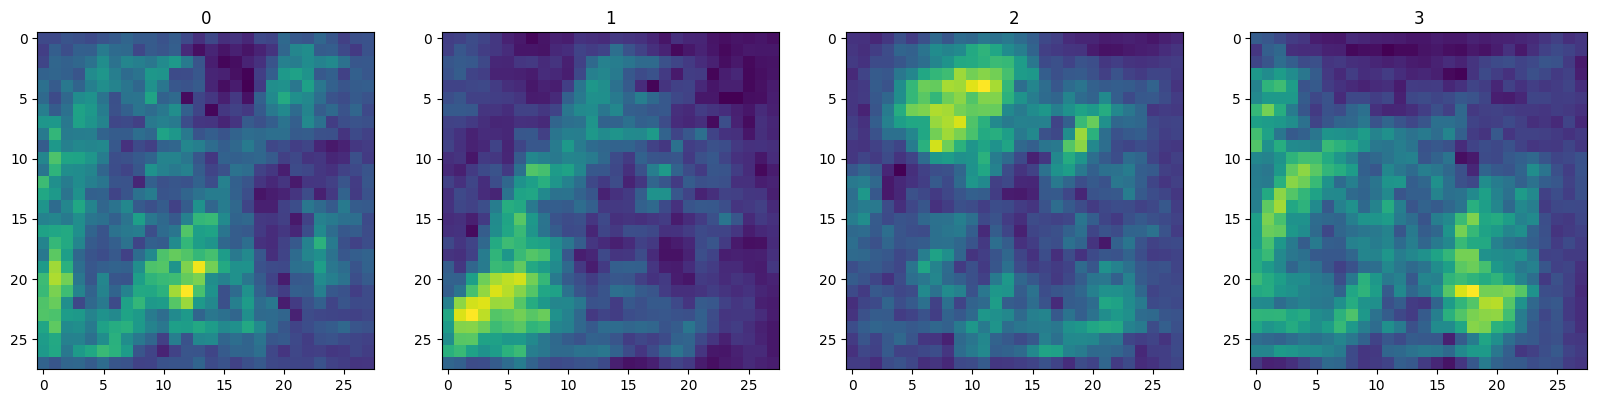

In [70]:
#generate new fashion
img = generator.predict(np.random.randn(4,128,1))

#setup subplot formatting ax- individual subplot
fig, ax = plt.subplots(ncols=4, figsize = (20,20))

#loop four time & get images
for idx, img in enumerate (img):

    #plot the image using a specific subplot
    ax[idx].imshow(np.squeeze(img))

    #appending the image label as the plot title
    ax[idx].title.set_text(idx)

Build Discriminator

In [61]:
#Determines whether the image is real or fake
def build_discriminator():
    model = Sequential()

    #first conv block
    model.add(Conv2D(32, 5, input_shape = (28,28,1))) #pass 32 filters with a shape of 5 by 5
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))#make it hard 4 a discriminator to learn

    #second conv block
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))#make it hard 4 a discriminator to learn

    #third conv block
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))#make it hard 4 a discriminator to learn

    #fourth conv block
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    #flatten then pass to dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))

    model.add(Dense(1, activation='sigmoid'))


    return model

In [62]:
discriminator = build_discriminator()

C:\Users\ibrahim.fadhili\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [63]:
discriminator.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_32 (Conv2D)              │ (None, 24, 24, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_32 (LeakyReLU)      │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 20, 20, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_33 (LeakyReLU)      │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 16, 16, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_34 (LeakyReLU)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 12, 12, 256)    │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_35 (LeakyReLU)      │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │        36,865 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,113,345 (4.25 MB)

 Trainable params: 1,113,345 (4.25 MB)

 Non-trainable params: 0 (0.00 B)

In [66]:
img = img[0]

In [67]:
img.shape

(28, 28, 1)

In [72]:
discriminator.predict(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


array([[0.507235  ],
       [0.50719887],
       [0.50719666],
       [0.50725937]], dtype=float32)

Not confident whether its real / fake at 0.5

# Custom Training Loops
To train both generator & dicriminator simultaneously

In [73]:
#Set up losses & Optimizers
#Adam is going to be the optimizer for both
from tensorflow.keras.optimizers import Adam

#BinaryCrossentropy is gonna be the loss for both
from tensorflow.keras.losses import BinaryCrossentropy

We're basically rewarding our generator 4 tricking the dicriminator & also rewarding our discriminator 4 determining the right image

In [75]:
#create instances

g_opt = Adam(learning_rate=0.0001) #faster than learning rate for discriminator
d_opt = Adam(learning_rate=0.00001)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

Setting up Subclass Model

In [76]:
#importing the base model class to training step
from tensorflow.keras.models import Model

In [ ]:
#define sub class model

class FashionGAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs): #keyword args, positional args
        #pass through args and kwargs to base class
        super().__init__(*args, **kwargs)

        #set up attributes for discriminator & generator
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        #compile with base class
        super().compile(*args, **kwargs)

        #set up attributes for discriminator & generator
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss

        self.discriminator = discriminator

    def train_step(self, batch):
        #get the data
        real_images = batch
        fake_images = self.generator(tf.random.normal((128,128,1)), training = False)

        #train the discriminator
        with tf.GradientTape() as d_tape:

            #pass the real & fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training = True)
            yhat_fake = self.discriminator(fake_images, training = True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis = 0)

            #create labels for real & fake images
            y_realfake = tf.compat([tf.zeros_like])
            #add noise to the outputs
            #Calculate loss
            #apply backpropagation

        pass